## BatchNormalization
批量归一化
$$\mu_b = \frac{1}{|B|} \sum_{i \in B}{x_i} \quad \sigma_B^2 = \frac{1}{|B|} \sum_{i \in B}{(x_i - \mu_B)^2 + \epsilon}$$

$$x_{i+1} = \gamma \frac{x_i - \mu}{\sigma} + \beta \quad \text{where} \space \gamma \space \text{and} \space \beta \space \text{is learnable}$$

- 通道层是卷积层的一个特征维度
- BN可以作用在
  - 全连接层和卷积层的输出上， 激活函数之前
  - 全连接层和卷积层的输入上
- 对于全连接层，作用在特征维度，输入是一个$b \times m$的矩阵，其中b为batch_size，m为特征数，就是对每个特征做归一化
- 对于卷积层，作用在通道上，把一个像素看作是一个样本，你的通道数就是特征数，一个通道就是一个像素的一个特征，因此是在同一通道上算均值和方差然后做归一化
- 后续有论文指出 BN **是通过在batch中加入噪音控制模型复杂度**， 因此没必要和DropOut混合使用

<img src='../images/28image1.png' width='400'>

- BatchNormalization固定小批量中的均值和方差，然后学习出合适的偏移和缩放
- 可以 **加速收敛**， 但是不会改变模型精度

In [4]:
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 如果是预测模式
    if not torch.is_grad_enabled():
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:  # 如果是训练模式
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2: # 全连接层使用
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 4维数据，在通道维度计算均值方差
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data


In [5]:
class BatchNorm(nn.Module):
    # num_features表示特征有多少个，输出维度或者输出通道数
    # num_dims表示输入数据的维度，2表示全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.ones(shape)
        self.moving_var = torch.zeros(shape)
    
    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta,
                                                          self.moving_mean, self.moving_var, eps=1e-5,
                                                          momentum=0.9)
        return Y

loss 0.244, train acc 0.910, test acc 0.868
11922.6 examples/sec on cuda:0


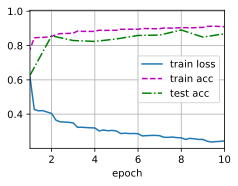

In [6]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, 4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, 4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16 * 4 * 4, 120), BatchNorm(120, 2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, 2), nn.Sigmoid(),
    nn.Linear(84, 10)
)

lr, num_epochs, batch_size = 1.0, 10, 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

- 归一化和normalization不是一回事，均值变1，方差变0不是叫normalization
- 权重衰退是缓解过拟合，归一化是加速训练
- batch norm一般用在网络比较深的时候